In [2]:
import json
from sentence_transformers import SentenceTransformer, util
import pandas as pd

In [4]:
with open("reqs_extraction/experiment_output/rag-lite-plannet-reqs-processed_v0.json") as f:
    data = json.load(f)

In [17]:
reqs = []
for datum in data:
    if 'processed_requirements' in datum:
        reqs.extend([x['Requirement*'] for x in datum['processed_requirements']])

In [20]:
model = SentenceTransformer("all-mpnet-base-v2")
req_embeddings = [model.encode(req) for req in reqs]


In [26]:
text_to_embed = [{'text': x, 'embedding': [float(z) for z in y]} for x,y in zip(reqs, req_embeddings)]
with open("reqs_extraction/experiment_output/req_text_embedding.json", "w+") as f:
    json.dump(text_to_embed, f, indent=2)

In [13]:
datum.keys()

dict_keys(['file_name', 'chunk_index', 'total_chunks', 'chunk', 'response'])

In [ ]:
datakeys = set()
for datum in data:
    datakeys.add(frozenset(datum.keys()))

In [16]:
datakeys

{frozenset({'chunk', 'chunk_index', 'file_name', 'response', 'total_chunks'}),
 frozenset({'chunk',
            'chunk_index',
            'file_name',
            'llm_response',
            'processed_requirements',
            'response',
            'selected_examples',
            'total_chunks'}),
 frozenset({'chunk',
            'chunk_index',
            'file_name',
            'llm_response',
            'processed_requirements',
            'response',
            'selected_examples',
            'total_chunks',
            'unprocessable_requirements'})}

In [27]:
from itertools import product

for x in product(text_to_embed, text_to_embed):
    print(x)
    break

({'text': "Server SHALL support the CodeSystem 'DeliveryMethodCS' with URL 'http://hl7.org/fhir/us/davinci-pdex-plan-net/CodeSystem/DeliveryMethodCS'", 'embedding': [0.00697505846619606, 0.016427630558609962, 0.01356743648648262, -0.006002660840749741, -0.005992749705910683, 0.031453993171453476, 0.028404895216226578, 0.043311625719070435, 0.0025450580287724733, 0.007476839702576399, 0.03057660348713398, 0.007559694815427065, 0.01672084629535675, 0.05317109078168869, 0.015061195008456707, 0.011600960046052933, -0.030413750559091568, 0.05520075559616089, -0.06618881970643997, -0.0505419485270977, -0.016734007745981216, -0.009443833492696285, 0.02026604861021042, -0.041308220475912094, 0.04942717403173447, -0.028837870806455612, -0.03742273896932602, 0.005713489837944508, -0.025584591552615166, -0.060709398239851, 0.04221047833561897, 0.0025893966667354107, 0.06440418213605881, -0.055025700479745865, 1.7966793848245288e-06, -0.03413321077823639, 0.02912859246134758, 0.03975401446223259, 

In [30]:
prod_list = list(product(text_to_embed, text_to_embed))

423801

In [ ]:
scored_prod_list = [['Requirement1', "Requirement2", "Similarity Score"]]
for i, prod in enumerate(prod_list):
    counter = i+1
    if counter % 10000 == 0:
        print(f"Pair {counter} of {len(prod_list)}")
    if prod[0]['text'] != prod[1]['text']:
        emb0 = prod[0]['embedding']
        emb1 = prod[1]['embedding']
        score = float(util.pytorch_cos_sim(emb0, emb1)[0][0])
        scored_prod_list.append([prod[0]['text'], prod[1]['text'], score])
print(f"Pair {counter} of {len(prod_list)}")

Pair 1000 of 423801
Pair 2000 of 423801
Pair 3000 of 423801
Pair 4000 of 423801
Pair 5000 of 423801
Pair 6000 of 423801
Pair 7000 of 423801
Pair 8000 of 423801
Pair 9000 of 423801
Pair 10000 of 423801
Pair 11000 of 423801
Pair 12000 of 423801
Pair 13000 of 423801
Pair 14000 of 423801
Pair 15000 of 423801
Pair 16000 of 423801
Pair 17000 of 423801
Pair 18000 of 423801
Pair 19000 of 423801
Pair 20000 of 423801
Pair 21000 of 423801
Pair 22000 of 423801
Pair 23000 of 423801
Pair 24000 of 423801
Pair 25000 of 423801
Pair 26000 of 423801
Pair 27000 of 423801
Pair 28000 of 423801
Pair 29000 of 423801
Pair 30000 of 423801
Pair 31000 of 423801
Pair 32000 of 423801
Pair 33000 of 423801
Pair 34000 of 423801
Pair 35000 of 423801
Pair 36000 of 423801
Pair 37000 of 423801
Pair 38000 of 423801
Pair 39000 of 423801
Pair 40000 of 423801
Pair 41000 of 423801
Pair 42000 of 423801
Pair 43000 of 423801
Pair 44000 of 423801
Pair 45000 of 423801
Pair 46000 of 423801
Pair 47000 of 423801
Pair 48000 of 423801
P

In [ ]:
df = pd.DataFrame(scored_prod_list[1:], columns=scored_prod_list[0])
df.head()

,Requirement1,Requirement2,Similarity Score
0,Server SHALL support the CodeSystem 'DeliveryM...,The DeliveryMethodCS CodeSystem SHALL include ...,0.504868
1,Server SHALL support the CodeSystem 'DeliveryM...,The DeliveryMethodCS CodeSystem SHALL include ...,0.520903
2,Server SHALL support the CodeSystem 'DeliveryM...,Servers SHALL support searching OrganizationAf...,0.279096
3,Server SHALL support the CodeSystem 'DeliveryM...,The 'specialty' search parameter for Organizat...,0.252866
4,Server SHALL support the CodeSystem 'DeliveryM...,The 'specialty' search parameter for Organizat...,0.198458


<Axes: >

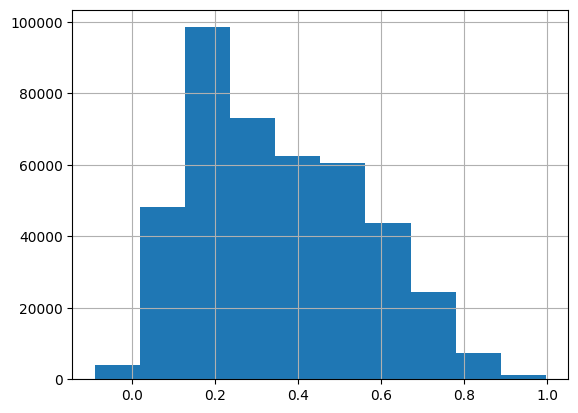

In [44]:
df["Similarity Score"].hist()

In [45]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

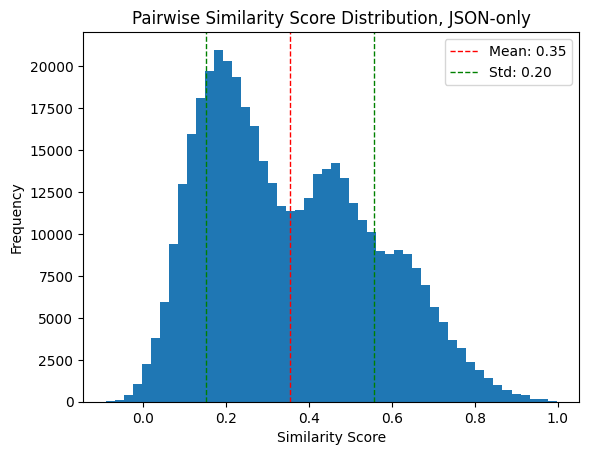

In [58]:
avg = np.mean(df['Similarity Score'])
std = np.std(df['Similarity Score'])

n, bins, patches = plt.hist(df['Similarity Score'], bins=50)

plt.axvline(avg, color='r', linestyle='dashed', linewidth=1, label=f'Mean: {avg:.2f}')
plt.axvline(avg + std, color='g', linestyle='dashed', linewidth=1, label=f'Std: {std:.2f}')
plt.axvline(avg - std, color='g', linestyle='dashed', linewidth=1)
plt.xlabel('Similarity Score')
plt.ylabel('Frequency')
plt.title('Pairwise Similarity Score Distribution, JSON-only')
plt.legend()
plt.savefig("jsononlyscores.pdf",bbox_inches="tight")
plt.show()

In [51]:
from scipy import stats

iqr = stats.iqr(df['Similarity Score'])

In [53]:
iqr*2*(df.shape[0]**(1/3))

47.472410139674984

In [59]:
df

,Requirement1,Requirement2,Similarity Score
0,Server SHALL support the CodeSystem 'DeliveryM...,The DeliveryMethodCS CodeSystem SHALL include ...,0.504868
1,Server SHALL support the CodeSystem 'DeliveryM...,The DeliveryMethodCS CodeSystem SHALL include ...,0.520903
2,Server SHALL support the CodeSystem 'DeliveryM...,Servers SHALL support searching OrganizationAf...,0.279096
3,Server SHALL support the CodeSystem 'DeliveryM...,The 'specialty' search parameter for Organizat...,0.252866
4,Server SHALL support the CodeSystem 'DeliveryM...,The 'specialty' search parameter for Organizat...,0.198458
...,...,...,...
422983,The Extension SHALL NOT have a value[x],Extension:daysOfWeek.value[x] SHALL be bound t...,0.378213
422984,The Extension SHALL NOT have a value[x],Extension:allDay SHALL have a value[x] of type...,0.524188
422985,The Extension SHALL NOT have a value[x],Extension:availableStartTime SHALL have a valu...,0.480116
422986,The Extension SHALL NOT have a value[x],Extension:availableEndTime SHALL have a value[...,0.519040


In [60]:
df.to_csv("requirement_similarity.csv")

In [6]:
df = pd.read_csv("requirement_similarity.csv").iloc[:,1:]

In [7]:
df.head()

,Requirement1,Requirement2,Similarity Score
0,Server SHALL support the CodeSystem 'DeliveryM...,The DeliveryMethodCS CodeSystem SHALL include ...,0.504868
1,Server SHALL support the CodeSystem 'DeliveryM...,The DeliveryMethodCS CodeSystem SHALL include ...,0.520903
2,Server SHALL support the CodeSystem 'DeliveryM...,Servers SHALL support searching OrganizationAf...,0.279096
3,Server SHALL support the CodeSystem 'DeliveryM...,The 'specialty' search parameter for Organizat...,0.252866
4,Server SHALL support the CodeSystem 'DeliveryM...,The 'specialty' search parameter for Organizat...,0.198458


In [10]:
df.shape

(422988, 3)

In [8]:
df.drop_duplicates(subset=['Requirement1', 'Requirement2'])

,Requirement1,Requirement2,Similarity Score
0,Server SHALL support the CodeSystem 'DeliveryM...,The DeliveryMethodCS CodeSystem SHALL include ...,0.504868
1,Server SHALL support the CodeSystem 'DeliveryM...,The DeliveryMethodCS CodeSystem SHALL include ...,0.520903
2,Server SHALL support the CodeSystem 'DeliveryM...,Servers SHALL support searching OrganizationAf...,0.279096
3,Server SHALL support the CodeSystem 'DeliveryM...,The 'specialty' search parameter for Organizat...,0.252866
4,Server SHALL support the CodeSystem 'DeliveryM...,The 'specialty' search parameter for Organizat...,0.198458
...,...,...,...
422983,The Extension SHALL NOT have a value[x],Extension:daysOfWeek.value[x] SHALL be bound t...,0.378213
422984,The Extension SHALL NOT have a value[x],Extension:allDay SHALL have a value[x] of type...,0.524188
422985,The Extension SHALL NOT have a value[x],Extension:availableStartTime SHALL have a valu...,0.480116
422986,The Extension SHALL NOT have a value[x],Extension:availableEndTime SHALL have a value[...,0.519040


In [15]:
subdf = df.loc[:,['Requirement1', 'Requirement2']]

dupes = subdf.T.apply(sorted).T.duplicated()

deduped = df[~dupes]

deduped.head()

,Requirement1,Requirement2,Similarity Score
0,Server SHALL support the CodeSystem 'DeliveryM...,The DeliveryMethodCS CodeSystem SHALL include ...,0.504868
1,Server SHALL support the CodeSystem 'DeliveryM...,The DeliveryMethodCS CodeSystem SHALL include ...,0.520903
2,Server SHALL support the CodeSystem 'DeliveryM...,Servers SHALL support searching OrganizationAf...,0.279096
3,Server SHALL support the CodeSystem 'DeliveryM...,The 'specialty' search parameter for Organizat...,0.252866
4,Server SHALL support the CodeSystem 'DeliveryM...,The 'specialty' search parameter for Organizat...,0.198458


In [ ]:
cutoffs = [0.8, 0.85, 0.9, 0.95]
reqs = deduped.Requirement1.unique()
for cutoff in cutoffs:
    subdf = deduped[deduped["Similarity Score"].astype(float) >= cutoff]
    group_map = {}
    for req in reqs:
        group_actions = subdf[(subdf.Requirement1 == req)|(subdf.Requirement2 == req)]
        if group_actions.shape[0] == 0:
            group_map[req] = set([req])
        else:
            for _, group_action in group_actions.iterrows():
                if (group_action.Requirement1 in group_map) and not (group_action.Requirement2 in group_map):
                    group_to_update = 
        

In [22]:
group_actions


,Requirement1,Requirement2,Similarity Score
